In [1]:
# Run this code to make Jupyter print every
# printable statement and not just the last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# To visualize the data
import matplotlib.pyplot as plt

# Generic libraries
import seaborn as sns
import pandas as pd
import numpy as np

# Regression models
import sklearn
import scipy
from scipy.stats import t
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV #split the data into training and test
from sklearn.linear_model import LinearRegression #linear regression
from sklearn.preprocessing import PolynomialFeatures #for polynomial regression
from sklearn.metrics import r2_score, mean_squared_error

# 5-folds crossvalidation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline


In [2]:
training_set_complete = pd.read_csv("data/training_set_online_shoppers_intention.csv")
all_categories_browser = list(range(1,14))
all_categories_traffic_type = list(range(1,21))
training_set_complete['Browser'] = training_set_complete['Browser'].astype('category').cat.set_categories(all_categories_browser)
training_set_complete['TrafficType'] = training_set_complete['TrafficType'].astype('category').cat.set_categories(all_categories_traffic_type)
training_set_complete = pd.get_dummies(training_set_complete, columns=['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType','Weekend'], drop_first=False)
#training_set_complete['Weekend'] = np.where(training_set_complete['Weekend']=='True',1,0)
missing_values = training_set_complete[training_set_complete['ExitRates'].isna()]
training_set = training_set_complete[training_set_complete['ExitRates'].isna()==False]

In [3]:
X = training_set.drop(columns=['ExitRates','Revenue','Unnamed: 0'])
y = training_set['ExitRates']

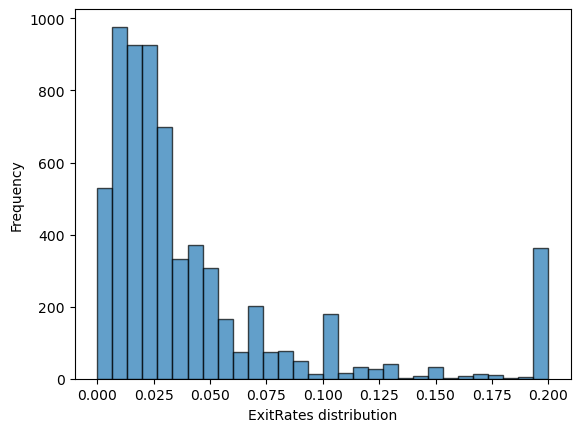

In [4]:
# Plotta l'istogramma
plot = plt.hist(np.array(y), bins=30, edgecolor='black', alpha=0.7)

# Aggiungi etichette e titolo al grafico
x_lab = plt.xlabel('ExitRates distribution')
y_lab = plt.ylabel('Frequency')

# Mostra il grafico
plt.show(plot)
plt.show(x_lab)
plt.show(y_lab)

Qui ti ho plottato la distribuzione di y con una trasformazione y=y^(1/3). La distribuzione è bella: sembra quasi normale! Il problema è che quando la uso ho delle performance davvero peggiori :(. Il problema è che proprio a livello di residual plot ci sono delle cose che non vanno, quindi secondo me non è il massimo. Di tutte le distribuzioni che ho provato questa mi sembra la migliore: quella logaritmica (con +1 per evitare problemi con lo zero) rimaneva quasi uguale.

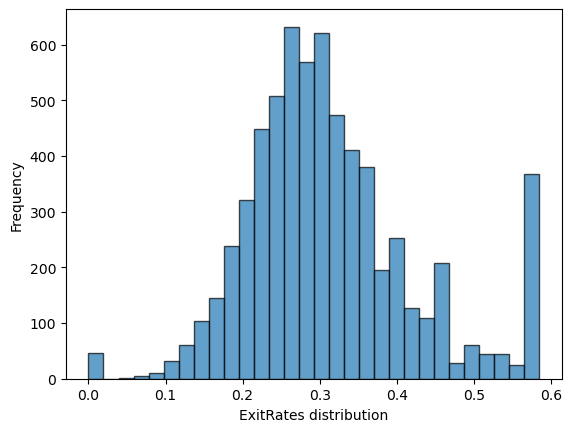

In [5]:
y_transformed = np.power(np.array(y),1/3)
#y_transformed = np.log(np.array(y)+1)
plot = plt.hist(y_transformed, bins=30, edgecolor='black', alpha=0.7)

# Aggiungi etichette e titolo al grafico
x_lab = plt.xlabel('ExitRates distribution')
y_lab = plt.ylabel('Frequency')

# Mostra il grafico
plt.show(plot)
plt.show(x_lab)
plt.show(y_lab)
#y = pd.Series(y_transformed)

## Linear and polynomial regression

In [6]:
test_size = 0.2
seed = 50
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

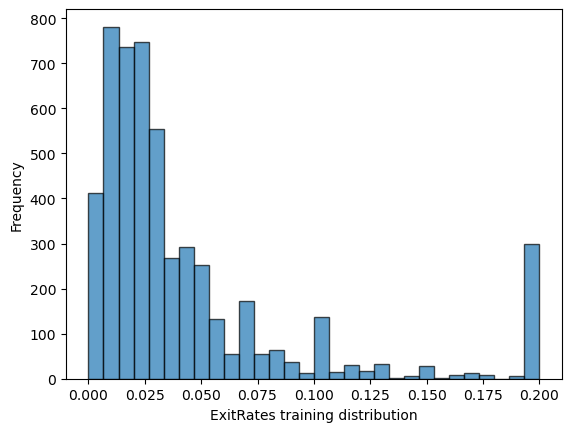

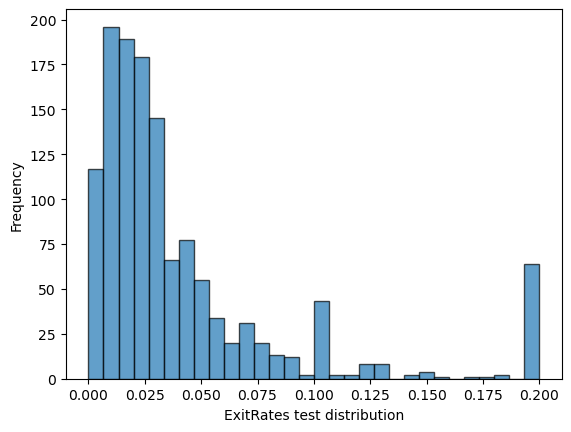

In [7]:
plot = plt.hist(y_train, bins=30, edgecolor='black', alpha=0.7)

# Aggiungi etichette e titolo al grafico
x_lab = plt.xlabel('ExitRates training distribution')
y_lab = plt.ylabel('Frequency')

# Mostra il grafico
plt.show(plot)
plt.show(x_lab)
plt.show(y_lab)

plot = plt.hist(y_test, bins=30, edgecolor='black', alpha=0.7)

# Aggiungi etichette e titolo al grafico
x_lab = plt.xlabel('ExitRates test distribution')
y_lab = plt.ylabel('Frequency')

# Mostra il grafico
plt.show(plot)
plt.show(x_lab)
plt.show(y_lab)

In [8]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)

mse_train = mean_squared_error(y_train, lin_reg.predict(X_train))
r2_train = r2_score(y_train, lin_reg.predict(X_train))
mse_test = mean_squared_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse_train)
print("R-squared:", r2_train)
print("Mean Squared Error:", mse_test)
print("R-squared:", r2_test)

LinearRegression()

Mean Squared Error: 0.0003181929846345731
R-squared: 0.8657159889012025
Mean Squared Error: 0.0003142776377671243
R-squared: 0.8513755772212931


Now we look at the coefficients:

In [9]:
# Create a dictionary to store feature-coefficient associations
feature_coefficients = {}

# Extract and store the coefficient for each feature
for feature_name, coefficient in zip(X.columns, lin_reg.coef_):
    feature_coefficients[feature_name] = coefficient

# Print the feature-coefficient associations
for feature, coefficient in feature_coefficients.items():
    print(f"Feature: {feature}, Coefficient: {coefficient}")

Feature: Administrative, Coefficient: -0.0008430258647781134
Feature: Administrative_Duration, Coefficient: -3.5734489638176386e-06
Feature: Informational, Coefficient: 0.00010410701021404726
Feature: Informational_Duration, Coefficient: -5.122096177739149e-07
Feature: ProductRelated, Coefficient: -0.00012242512119635374
Feature: ProductRelated_Duration, Coefficient: 4.5245005857522114e-07
Feature: BounceRates, Coefficient: 0.858644604913506
Feature: PageValues, Coefficient: -0.00013197512326430794
Feature: SpecialDay, Coefficient: 0.00702108105672436
Feature: Month_Aug, Coefficient: -0.0020460552747760957
Feature: Month_Dec, Coefficient: 0.00032949773775137886
Feature: Month_Feb, Coefficient: 0.0005874786099551998
Feature: Month_Jul, Coefficient: 0.0016744238034852093
Feature: Month_June, Coefficient: 0.005357044013378102
Feature: Month_Mar, Coefficient: -0.000667492392506859
Feature: Month_May, Coefficient: -0.0009931583828791946
Feature: Month_Nov, Coefficient: -0.000357097037774478

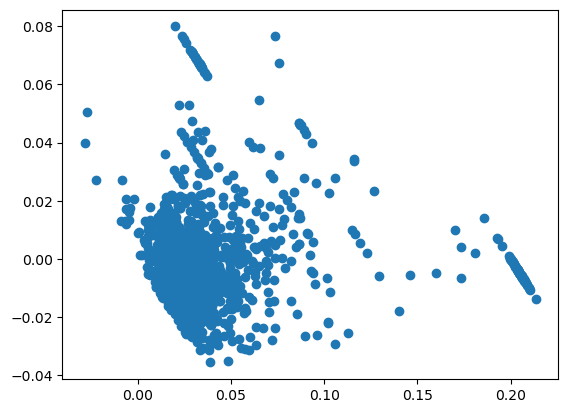

In [10]:
residuals = y_test-y_pred
plt.scatter(y_pred,residuals)
plt.show()

Now we check if we may have a better model with polynomial features:

In [11]:
r2_scorer = make_scorer(r2_score, greater_is_better=True)

# Validation
model = Pipeline([('poly', PolynomialFeatures(degree=1, include_bias=False)),
                  ('linear', LinearRegression(fit_intercept=True))])

# Select parameters to optimize
parameters = {'poly__degree': list(range(1,3))}
              #'linear__fit_intercept': [True, False],
              #'linear__normalize': [True, False]}

cv = GridSearchCV(model, parameters, scoring=r2_scorer, cv=5, refit=True)
cv.fit(X_train, y_train)
best_polynomial_model = cv.best_estimator_
print("Best Hyperparameters:", cv.best_params_)
print("Best R-squared Score:", cv.best_score_)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly',
                                        PolynomialFeatures(degree=1,
                                                           include_bias=False)),
                                       ('linear', LinearRegression())]),
             param_grid={'poly__degree': [1, 2]},
             scoring=make_scorer(r2_score))

Best Hyperparameters: {'poly__degree': 1}
Best R-squared Score: 0.8611976274313701


So if we consider all the variables the best model still be the one with grade 1.

## Ridge regression
We saw that the best degree is one. We want to see if we can improve it with ridge regression:

In [12]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

best_degree = 1
param_grid = {
    'ridge__alpha': [0.01, 0.1, 1.0, 10.0]  # Add more values if needed
}
best_degree = 2
pipeline = Pipeline([
    #('poly', PolynomialFeatures(degree=best_degree, include_bias=False)),
    ('scaler', scaler),
    ('ridge', Ridge())  # Ridge estimator without specifying alpha
])
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_alpha = grid_search.best_params_['ridge__alpha']
best_estimator = grid_search.best_estimator_
print("Best alpha:", best_alpha)
print("Best coefficients:", best_estimator.named_steps['ridge'].coef_)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': [0.01, 0.1, 1.0, 10.0]})

Best alpha: 10.0
Best coefficients: [-2.76946030e-03 -5.93549299e-04  1.27371175e-04 -6.43896147e-05
 -5.30047870e-03  7.28623736e-04  4.15646585e-02 -2.38132134e-03
  1.37693837e-03 -2.98358688e-04  2.55693366e-04  1.26640382e-04
  3.83910522e-04  8.80587873e-04 -9.35098491e-05 -2.53182747e-04
  2.35983876e-05 -3.23372095e-04 -2.83132572e-04 -6.34398899e-05
  8.74363819e-04 -1.01605588e-03  2.71647450e-04 -3.15828154e-05
 -4.43606208e-04 -6.39954407e-05 -4.25938616e-04 -1.22064745e-05
  3.56968723e-05  3.45360184e-04  2.30070337e-04 -8.49541780e-05
 -1.39995835e-04  2.05698797e-04  6.92905852e-05  0.00000000e+00
 -3.28407394e-04 -3.15828154e-05 -1.24976246e-04 -6.76836082e-04
  1.56894635e-04 -1.03823604e-04  2.64842132e-04  6.89440666e-05
  5.60434662e-05 -2.97652880e-04 -4.97600191e-04 -3.92260371e-04
  4.24503170e-04  4.96451693e-04 -1.14272116e-03  7.98559774e-04
 -6.51680691e-04  1.23925598e-04  2.69952831e-04  2.51838158e-05
 -1.12682815e-04 -1.56556141e-05 -1.41690217e-04  1.40

In [13]:
best_model_ridge = grid_search.best_estimator_
y_pred = best_model_ridge.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best alpha:", best_alpha)
print("Best coefficients:", best_model_ridge.named_steps['ridge'].coef_)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Best alpha: 10.0
Best coefficients: [-2.76946030e-03 -5.93549299e-04  1.27371175e-04 -6.43896147e-05
 -5.30047870e-03  7.28623736e-04  4.15646585e-02 -2.38132134e-03
  1.37693837e-03 -2.98358688e-04  2.55693366e-04  1.26640382e-04
  3.83910522e-04  8.80587873e-04 -9.35098491e-05 -2.53182747e-04
  2.35983876e-05 -3.23372095e-04 -2.83132572e-04 -6.34398899e-05
  8.74363819e-04 -1.01605588e-03  2.71647450e-04 -3.15828154e-05
 -4.43606208e-04 -6.39954407e-05 -4.25938616e-04 -1.22064745e-05
  3.56968723e-05  3.45360184e-04  2.30070337e-04 -8.49541780e-05
 -1.39995835e-04  2.05698797e-04  6.92905852e-05  0.00000000e+00
 -3.28407394e-04 -3.15828154e-05 -1.24976246e-04 -6.76836082e-04
  1.56894635e-04 -1.03823604e-04  2.64842132e-04  6.89440666e-05
  5.60434662e-05 -2.97652880e-04 -4.97600191e-04 -3.92260371e-04
  4.24503170e-04  4.96451693e-04 -1.14272116e-03  7.98559774e-04
 -6.51680691e-04  1.23925598e-04  2.69952831e-04  2.51838158e-05
 -1.12682815e-04 -1.56556141e-05 -1.41690217e-04  1.40

The $R^2$ decreased wrt the linear model. In this case, it may be correct, because all our coefficients are very small and Ridge regression is more appropriate when we have some high coefficients that we want to shrink to 0.

## Lasso

In [14]:
from sklearn.linear_model import Lasso
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

best_degree = 1
param_grid = {
    'lasso__alpha': [0.01, 0.1, 1.0, 10.0]  # Add more values if needed
}
best_degree = 2
pipeline = Pipeline([
    #('poly', PolynomialFeatures(degree=best_degree, include_bias=False)),
    ('scaler', scaler),
    ('lasso', Lasso())  # Ridge estimator without specifying alpha
])
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_alpha = grid_search.best_params_['lasso__alpha']
best_estimator = grid_search.best_estimator_
print("Best alpha:", best_alpha)
print("Best coefficients:", best_estimator.named_steps['lasso'].coef_)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('lasso', Lasso())]),
             param_grid={'lasso__alpha': [0.01, 0.1, 1.0, 10.0]})

Best alpha: 0.01
Best coefficients: [-0.         -0.         -0.         -0.         -0.         -0.
  0.03448456 -0.          0.         -0.         -0.          0.
  0.          0.          0.          0.         -0.         -0.
 -0.          0.         -0.          0.         -0.         -0.
 -0.          0.          0.          0.         -0.          0.
  0.          0.          0.          0.          0.          0.
 -0.         -0.         -0.          0.          0.          0.
  0.          0.          0.         -0.         -0.         -0.
  0.          0.         -0.          0.         -0.         -0.
  0.         -0.         -0.         -0.         -0.          0.
  0.          0.         -0.          0.         -0.          0.
  0.         -0.          0.         -0.          0.          0.
  0.         -0.        ]


In [15]:
best_model_lasso = grid_search.best_estimator_
y_pred = best_model_lasso.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best alpha:", best_alpha)
print("Best coefficients:", best_model_lasso.named_steps['lasso'].coef_)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Best alpha: 0.01
Best coefficients: [-0.         -0.         -0.         -0.         -0.         -0.
  0.03448456 -0.          0.         -0.         -0.          0.
  0.          0.          0.          0.         -0.         -0.
 -0.          0.         -0.          0.         -0.         -0.
 -0.          0.          0.          0.         -0.          0.
  0.          0.          0.          0.          0.          0.
 -0.         -0.         -0.          0.          0.          0.
  0.          0.          0.         -0.         -0.         -0.
  0.          0.         -0.          0.         -0.         -0.
  0.         -0.         -0.         -0.         -0.          0.
  0.          0.         -0.          0.         -0.          0.
  0.         -0.          0.         -0.          0.          0.
  0.         -0.        ]
Mean Squared Error: 0.00045944184144113475
R-squared: 0.782726257681838


In [16]:
coefficients_df = pd.DataFrame({
    #'Feature': X.columns,
    'Ridge Coefficients': best_model_ridge.named_steps['ridge'].coef_,
    'Lasso Coefficients': best_model_lasso.named_steps['lasso'].coef_
})

# Print the entire DataFrame to see the coefficients with the associated variables
coefficients_df

,Ridge Coefficients,Lasso Coefficients
0,-0.002769,-0.0
1,-0.000594,-0.0
2,0.000127,-0.0
3,-0.000064,-0.0
4,-0.005300,-0.0
...,...,...
69,-0.001609,-0.0
70,0.001370,0.0
71,0.001250,0.0
72,0.000200,0.0


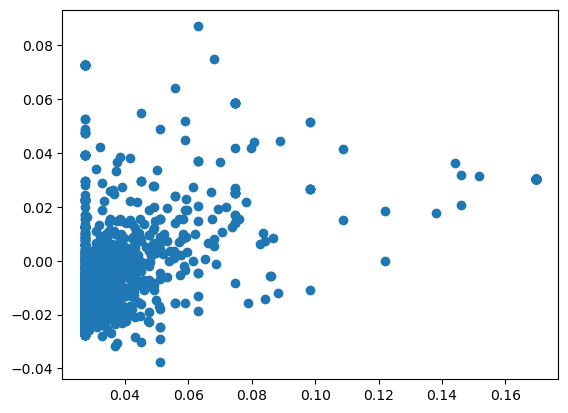

In [17]:
residuals = y_test-y_pred
plt.scatter(y_pred,residuals)
plt.show()

To perform an accurate evaluation of the models we compute the RMSE throug 5-cv. As we can see from the results, the linear regression shows a better score wrt ridge and lasso. 

In [18]:
# Linear Regression
linear_reg_score = cross_val_score(lin_reg, X, y, cv=5, scoring='neg_mean_squared_error')
linear_reg_rmse = np.sqrt(-linear_reg_score.mean())

# Ridge Regression
ridge_reg_score = cross_val_score(best_model_ridge, X, y, cv=5, scoring='neg_mean_squared_error')
ridge_reg_rmse = np.sqrt(-ridge_reg_score.mean())

# Lasso Regression
lasso_reg_score = cross_val_score(best_model_lasso, X, y, cv=5, scoring='neg_mean_squared_error')
lasso_reg_rmse = np.sqrt(-lasso_reg_score.mean())

# Evaluation
models = ['Linear Regression', 'Ridge Regression', 'Lasso Regression']
rmse_scores = [linear_reg_rmse, ridge_reg_rmse, lasso_reg_rmse]

for model, rmse_score in zip(models, rmse_scores):
    print(f"{model}: RMSE = {rmse_score}")

# Select the best model based on the RMSE score and further analysis


Linear Regression: RMSE = 0.01799229772797302
Ridge Regression: RMSE = 0.017991899456674336
Lasso Regression: RMSE = 0.022099965523026077


## Forward stepwise selection

In [19]:
# Convert back from numpy arrays to data frames
X_all_features = list(np.delete(X.columns.values, [np.where(training_set.columns.values=='Unnamed: 0'),np.where(training_set.columns.values=='ExitRates'),np.where(training_set.columns.values=='Revenue')], axis=None))
X_train_pd = pd.DataFrame(X_train, columns=X_all_features)
X_test_pd = pd.DataFrame(X_test, columns=X_all_features)

In [20]:
def rss(y_true, y_pred):
    # First we make sure the shapes are the same
    y_true = y_true.reshape(y_pred.shape)
    return np.sum((y_true - y_pred) ** 2)

def estimate_sigma(Xtrain_pd, ytrain):
    # Sigma is usually estimated using the model with all features
    n, p = Xtrain_pd.shape
    model = LinearRegression(fit_intercept=True)
    model.fit(Xtrain_pd, ytrain)
    y_pred = model.predict(Xtrain_pd)
    RSS = rss(y_pred, ytrain)
    RSE = np.sqrt(RSS / (n-p))
    return RSE

def bic(y_pred, y_true, n, d, sigma):
    sigma2 = sigma**2
    return (rss(y_pred, y_true) + np.log(n)*d*sigma2) / (n*sigma2)

def get_sigma_scorer(metric, sigma):
    def scorer(model, X, y):
        n, d = X.shape
        y_pred = model.predict(X)
        return metric(y_pred, y, n, d, sigma)
    
    return scorer

def get_evaluator(scorer):
    def evaluator(model, X, y, trained=False):
        if not trained:
            model = model.fit(X, y)
        score = scorer(model, X, y)
        return model, score
    return evaluator  

from sklearn.dummy import DummyRegressor

def forward_selection(Xtrain_pd, ytrain, Xtest_pd, ytest,
                      candidates_evaluator, candidates_argbest, # Metric to be used at 2.b
                      subsets_evaluator, subsets_argbest,       # Metric to be used at 3
                      test_evaluator=None, test_argbest=None,
                      verbose=True, weight_step3=0):   
    test_evaluator = subsets_evaluator if not test_evaluator else test_evaluator
    test_argbest = subsets_argbest if not test_argbest else test_argbest
    
    # Global variable init
    # ====================
    num_features = Xtrain_pd.shape[-1]
    best_candidate_metric = []
    # subsets_* are lists containing one value for each Mk model (the best of the Mk candidates)
    subsets_test = []
    subsets_metric = []        # The best metric of each subset of dimension 'dim'
    subsets_best_features = [] # The best features combination in each subset of dimension 'dim'
    # A figure to keep track of candidates scores in each Mk subset
    num_evaluations = 0        # A conter to keep track of the total number of trials
    
    selected_features = []  # <------ !! We keep track of selected features !!
    all_features = Xtrain_pd.columns
    
    
    # 1. Train M0
    # ===========
    model = DummyRegressor()
    # Compute (2.b) metrics
    model, score = candidates_evaluator(model, Xtrain_pd[[]], ytrain)
    best_candidate_metric.append(score)
    subsets_best_features.append([])
    # Compute metric for step 3.
    _, score = subsets_evaluator(model, Xtrain_pd[[]], ytrain, trained=True)
    subsets_metric.append(score)
    _, score = test_evaluator(model, Xtrain_pd[[]], ytrain, trained=True)
    subsets_test.append(score)
    
    # 2. Evaluate all Mk candidates with
    #    k=0...P features
    # =========================================
    #!! The loop condition is slightly changed
    #!! How many iterations we need to perform?
    for dim in range(num_features):
        candidate_metrics = [] # Keep track of candidates metrics. Will be used to select the best
        candidate_models = []  # Keep track of candidates trained models
        
        # 2.a Given the previous Mk model, test remaining
        # features and select the one providing the best
        # performance increment
        # ===============================================
        remaining_features = Xtrain_pd.columns.difference(selected_features)
        
        for new_column in remaining_features:
            Xtrain_sub = Xtrain_pd[selected_features+[new_column]].to_numpy()
            model = LinearRegression(fit_intercept=True)
            model, score = candidates_evaluator(model, Xtrain_sub, ytrain)
            candidate_models.append(model)
            candidate_metrics.append(score)
            num_evaluations += 1
            
       
        # 2.b Select the best candidate in (2.a)
        # ===============================================
        idx_best_candidate = candidates_argbest(candidate_metrics)
        #!!! Update selected feature
        # ==========================
        selected_features.append(remaining_features[idx_best_candidate])
        # Save best candidate features
        best_candidate_metric.append(candidate_metrics[idx_best_candidate])
        best_features = selected_features.copy()
        subsets_best_features.append(best_features)
        
        # Compute metric for step 3.
        best_subset_model = candidate_models[idx_best_candidate]
        best_subset_Xtrain = Xtrain_pd[best_features].to_numpy()
        _, score = subsets_evaluator(best_subset_model, best_subset_Xtrain, ytrain, trained=True)
        subsets_metric.append(score)
        best_subset_Xtest = Xtest_pd[best_features].to_numpy()
        _, score_test = test_evaluator(best_subset_model, best_subset_Xtest, ytest, trained=True)
        subsets_test.append(score_test)
        num_evaluations += weight_step3 
        
        if verbose:
            print("............")
            print("Best model (M{}) with {} features: {}".format(dim, dim+1, best_features))
            print("M{} subset score (3.): {}".format(dim, score))
        
    # 3. Among all best candidates with increasing number
    #    of features, select the best one
    # ===================================================
    best_subset_idx = subsets_argbest(subsets_metric)
    best_features = subsets_best_features[best_subset_idx]
    
    if verbose:
        print("\n\nBest configuration has {} features".format(best_subset_idx))
        print("Features: {}".format(subsets_best_features[best_subset_idx]))
        print("Total number of trained models:", num_evaluations)
    return best_features
    

In [21]:
sigma = estimate_sigma(X_train_pd, y_train)

best_features = forward_selection(X_train_pd, y_train, X_test_pd, y_test,
                  get_evaluator(make_scorer(r2_score)), np.argmax, # 2.
                  get_evaluator(get_sigma_scorer(bic, sigma)), np.argmin, # 3.
                  get_evaluator(make_scorer(mean_squared_error)), np.argmin, # test
                  verbose=False)

In [22]:
X = X[best_features].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

degree = list(range(1,5))
val_scores = np.zeros(len(degree))
# Validation
for i, d in enumerate(degree):
    model = Pipeline([('poly', PolynomialFeatures(degree=d, include_bias=False)),
                      ('linear', LinearRegression(fit_intercept=True))])
    scores = cross_val_score(model, X_train, y_train, scoring=r2_scorer, cv=5)
    val_scores[i] = np.mean(scores)

# Identifies which is the best degree
best_model_idx = np.argmax(val_scores)
best_degree = degree[best_model_idx]
# And the corresponding (best) validation score
best_val_score = val_scores[best_model_idx]
print("Best degree: ", best_degree,
      "\nVal score: ", best_val_score)
    
    
# Train again the Pipeline using the best parameter and the whole training set
model = Pipeline([('poly', PolynomialFeatures(degree=best_degree, include_bias=False)),
                  ('linear', LinearRegression(fit_intercept=True))])
# Note: we train on X_train_small + X_val
model = model.fit(np.concatenate([X_train]), np.concatenate([y_train]))
y_predict = model.predict(X_test)
test_score = r2_score(y_test, y_predict)

print("Test score:", test_score)

Best degree:  2 
Val score:  0.8717429044960804
Test score: 0.8547526805621322


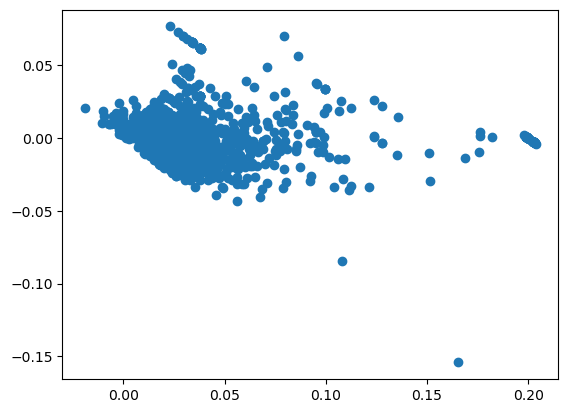

In [23]:
residuals = y_test-y_predict
plt.scatter(y_predict,residuals)
plt.show()

In [24]:
X_missing = missing_values[best_features].to_numpy()
X_missing.shape
values = model.predict(X_missing)
values = np.where(values < 0, 0, values)
values = np.where(values > 1, 1, values)
training_set_complete.loc[:,'ExitRates'] = training_set_complete.loc[:,'ExitRates'].fillna(pd.Series(values,missing_values.index))
training_set_complete

(2782, 9)

,Unnamed: 0,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,...,TrafficType_16,TrafficType_17,TrafficType_18,TrafficType_19,TrafficType_20,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor,Weekend_False,Weekend_True
0,3496,0,0.000000,0,0.0,5,19.000000,0.000000,0.080000,0.000000,...,0,0,0,0,0,0,0,1,1,0
1,9415,5,158.700000,0,0.0,51,1364.266667,0.007692,0.011987,0.000000,...,0,0,0,0,0,0,0,1,0,1
2,9419,7,87.916667,1,0.0,46,1621.025379,0.004082,0.020544,6.023523,...,0,0,0,0,0,0,0,1,1,0
3,3837,1,4.000000,0,0.0,37,1296.942857,0.013889,0.038530,0.000000,...,0,0,0,0,0,0,0,1,1,0
4,7305,2,132.400000,0,0.0,11,296.300000,0.000000,0.017246,0.000000,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9243,7878,10,130.550000,1,23.2,7,128.233333,0.006667,0.015238,0.000000,...,0,0,0,0,0,1,0,0,1,0
9244,6568,14,260.736111,3,186.5,51,2921.902778,0.013661,0.029891,8.339172,...,0,0,0,0,0,0,0,1,0,1
9245,6989,7,109.500000,0,0.0,25,349.696970,0.000000,0.019048,0.000000,...,0,0,0,0,0,0,0,1,1,0
9246,7640,4,82.700000,0,0.0,26,405.283333,0.000000,0.012974,0.000000,...,0,0,0,0,0,1,0,0,1,0


In [25]:
test_set = pd.read_csv("data/test_set_online_shoppers_intention.csv")
test_set['Browser'] = test_set['Browser'].astype('category').cat.set_categories(all_categories_browser)
test_set['TrafficType'] = test_set['TrafficType'].astype('category').cat.set_categories(all_categories_traffic_type)
test_set = pd.get_dummies(test_set, columns=['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType','Weekend'], drop_first=False)
#test_set['Weekend'] = np.where(test_set['Weekend']=='True',1,0)
missing_values_test = test_set[test_set['ExitRates'].isna()]
X_missing_test = missing_values_test[best_features].to_numpy()
X_missing_test.shape
values_test = model.predict(X_missing_test)
values_test = np.where(values_test < 0, 0, values_test)
test_set.loc[:,'ExitRates'] = test_set.loc[:,'ExitRates'].fillna(pd.Series(values_test,missing_values_test.index))

(917, 9)

In [26]:
training_set_complete.to_csv("training_set_complete.csv", index=False)
test_set.to_csv("test_set_complete.csv", index=False)

In [27]:
training_set_complete.columns

Index(['Unnamed: 0', 'Administrative', 'Administrative_Duration',
       'Informational', 'Informational_Duration', 'ProductRelated',
       'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues',
       'SpecialDay', 'Revenue', 'Month_Aug', 'Month_Dec', 'Month_Feb',
       'Month_Jul', 'Month_June', 'Month_Mar', 'Month_May', 'Month_Nov',
       'Month_Oct', 'Month_Sep', 'OperatingSystems_1', 'OperatingSystems_2',
       'OperatingSystems_3', 'OperatingSystems_4', 'OperatingSystems_5',
       'OperatingSystems_6', 'OperatingSystems_7', 'OperatingSystems_8',
       'Browser_1', 'Browser_2', 'Browser_3', 'Browser_4', 'Browser_5',
       'Browser_6', 'Browser_7', 'Browser_8', 'Browser_9', 'Browser_10',
       'Browser_11', 'Browser_12', 'Browser_13', 'Region_1', 'Region_2',
       'Region_3', 'Region_4', 'Region_5', 'Region_6', 'Region_7', 'Region_8',
       'Region_9', 'TrafficType_1', 'TrafficType_2', 'TrafficType_3',
       'TrafficType_4', 'TrafficType_5', 'TrafficType_6'

In [28]:
test_set.columns

Index(['Unnamed: 0', 'Administrative', 'Administrative_Duration',
       'Informational', 'Informational_Duration', 'ProductRelated',
       'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues',
       'SpecialDay', 'Revenue', 'Month_Aug', 'Month_Dec', 'Month_Feb',
       'Month_Jul', 'Month_June', 'Month_Mar', 'Month_May', 'Month_Nov',
       'Month_Oct', 'Month_Sep', 'OperatingSystems_1', 'OperatingSystems_2',
       'OperatingSystems_3', 'OperatingSystems_4', 'OperatingSystems_5',
       'OperatingSystems_6', 'OperatingSystems_7', 'OperatingSystems_8',
       'Browser_1', 'Browser_2', 'Browser_3', 'Browser_4', 'Browser_5',
       'Browser_6', 'Browser_7', 'Browser_8', 'Browser_9', 'Browser_10',
       'Browser_11', 'Browser_12', 'Browser_13', 'Region_1', 'Region_2',
       'Region_3', 'Region_4', 'Region_5', 'Region_6', 'Region_7', 'Region_8',
       'Region_9', 'TrafficType_1', 'TrafficType_2', 'TrafficType_3',
       'TrafficType_4', 'TrafficType_5', 'TrafficType_6'

In [29]:
list(range(1,21))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]